In [1]:
!pip install boto3 torch torchvision pandas pillow scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 39.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 143.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 21.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 58.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 159.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 55.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 44.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 71.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import os
import boto3
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import models, transforms
import torch
from io import BytesIO


bucket = 'snake-images-dataset'
prefix = 'dataset'
s3 = boto3.client('s3')

# Load pretrained ResNet18

In [10]:
import os
import boto3
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import models, transforms
import torch
from io import BytesIO


bucket = 'snake-images-datasets'
prefix = 'dataset'
s3 = boto3.client('s3')

# Load pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


output_csv = 'snake_features.csv'

# Write header once
if not os.path.exists(output_csv):
    df_header = pd.DataFrame(columns=[f'feature_{i}' for i in range(512)] + ['label', 'split'])
    df_header.to_csv(output_csv, index=False)

# Track progress
total_processed = 0

# Paginate all S3 objects under dataset
paginator = s3.get_paginator('list_objects_v2')
for result in paginator.paginate(Bucket=bucket, Prefix=prefix):
    rows = []
    for obj in result.get('Contents', []):
        key = obj['Key']
        if key.endswith('.jpg') or key.endswith('.png'):
            try:
                parts = key.split('/')
                split = parts[2]   # train / val / test
                label = parts[3]   # cobra / viper / etc.

                # Download and process image
                response = s3.get_object(Bucket=bucket, Key=key)
                image = Image.open(BytesIO(response['Body'].read())).convert('RGB')
                image = transform(image).unsqueeze(0)

                # Extract features
                with torch.no_grad():
                    embedding = resnet(image).squeeze().numpy()

                # Add row with features, label, and split info
                row = list(embedding) + [label, split]
                rows.append(row)
                total_processed += 1

                if total_processed % 50 == 0:
                    print(f" Processed {total_processed} images...")

            except Exception as e:
                print(f" Error processing {key}: {e}")

    # Append batch to CSV
    if rows:
        df = pd.DataFrame(rows, columns=[f'feature_{i}' for i in range(512)] + ['label', 'split'])
        df.to_csv(output_csv, mode='a', header=False, index=False)

print(f"\n🎉 Done! Extracted features for {total_processed} images and saved to {output_csv}")



🎉 Done! Extracted features for 0 images and saved to snake_features.csv


In [39]:
import pandas as pd

df = pd.read_csv('snake_features.csv')
df = pd.DataFrame(features)
df['label'] = labels

# Save to CSV
df.to_csv('snake_features.csv', index=False)
print(" Features saved to snake_features.csv")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 import pandas as pd                                                                         │
│    2                                                                                             │
│    3 df = pd.read_csv('snake_features.csv')                                                      │
│ ❱  4 df = pd.DataFrame(features)                                                                 │
│    5 df['label'] = labels                                                                        │
│    6                                                                                             │
│    7 # Save to CSV                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'features' is not defined

In [24]:
%%time

import os
import boto3
import re
import sagemaker

s3 = boto3.client('s3')

CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 11.8 ms


In [41]:
bucket_name = 'snake-images-datasets'
s3_key = 'dataset/snake_features.csv'

response = s3.get_object(Bucket=bucket_name, Key=s3_key)
file_content = response['Body'].read()

# Load CSV into pandas
df = pd.read_csv(BytesIO(file_content))

print("✅ DataFrame loaded. Shape:", df.shape)

✅ DataFrame loaded. Shape: (18968, 514)


In [43]:

print(df['split'].unique())

['train' 'test' 'val']


In [30]:
%%time
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the training data is located.
data_bucket = f"snake-images-datasets"
data_prefix = "dataset/snake_features"
data_bucket_path = f"s3://{data_bucket}"

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
output_bucket = sagemaker.Session().default_bucket()
s3_bucket_prefix = "csv/xgboost-model"
default_bucket_prefix = sagemaker.Session().default_bucket_prefix

# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    output_prefix = f"{default_bucket_prefix}/{s3_bucket_prefix}"
else:
    output_prefix = s3_bucket_prefix

output_bucket_path = f"s3://{output_bucket}"

CPU times: user 574 ms, sys: 7.31 ms, total: 582 ms
Wall time: 934 ms


In [45]:

print(df['split'].unique())

['train' 'test' 'val']


In [46]:
%%time

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import dump_svmlight_file

# Load your full feature CSV


label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Extract features and target
feature_cols = [col for col in df.columns if col.startswith("feature_")]

# Check how many rows are in each split
print("Split counts:\n", df['split'].value_counts())

# Process each split safely
for split in ["train", "val", "test"]:
    split_df = df[df["split"] == split]
    if len(split_df) == 0:
        print(f"⚠️ Skipping '{split}' split — it has no data!")
        continue  # skip to next one

    X_split = split_df[feature_cols]
    y_split = split_df["label"]
    dump_svmlight_file(X_split, y_split, f"{split}.libsvm", zero_based=True)

print("✅ Split done and saved as train.libsvm, val.libsvm, test.libsvm (if not empty)")


Split counts:
 train    15440
test      1848
val       1680
Name: split, dtype: int64
✅ Split done and saved as train.libsvm, val.libsvm, test.libsvm (if not empty)
CPU times: user 6.53 s, sys: 246 ms, total: 6.78 s
Wall time: 8.39 s


In [47]:
print(df['label'].value_counts())

1     2352
2     2352
3     2068
0     1948
10    1848
5     1680
4     1680
6     1680
9     1680
8     1512
7      168
Name: label, dtype: int64


In [48]:
print(df.shape)               # Check total rows
print(df['label'].nunique()) # Check how many unique labels exist
print(sorted(df['label'].unique()))  # Sorted unique label list

(18968, 514)
11
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [49]:
print(df['label'].unique())

[ 0  1  2  3  4  5  6  8  9 10  7]


In [51]:
bucket = "snake-images-datasets" 
prefix = "xgboost-snake-train-data"

s3 = boto3.client("s3")
for split in ["train", "val", "test"]:
    filename = f"{split}.libsvm"
    s3.upload_file(filename, bucket, f"{prefix}/{split}/{filename}")
    print(f" Uploaded {filename} to s3://{bucket}/{prefix}/{split}/")

 Uploaded train.libsvm to s3://snake-images-datasets/xgboost-snake-train-data/train/
 Uploaded val.libsvm to s3://snake-images-datasets/xgboost-snake-train-data/val/
 Uploaded test.libsvm to s3://snake-images-datasets/xgboost-snake-train-data/test/


In [52]:
%%time

from time import gmtime, strftime
import time
import boto3
import struct
import io
role = sagemaker.get_execution_role()
output_bucket = sagemaker.Session().default_bucket()


region = boto3.Session().region_name
client = boto3.client("sagemaker", region_name=region)
container = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.7-1")


training_job_name = f"xgboost-multiclass-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"

create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": f"s3://{output_bucket}/single-xgboost-multi"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.xlarge", "VolumeSizeInGB": 5},
    "TrainingJobName": training_job_name,
    "HyperParameters": {
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "multi:softmax",
        "num_class": "11",
        "num_round": "50",
        "verbosity": "2",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 3600},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://snake-images-datasets/xgboost-snake-train-data/train",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://snake-images-datasets/xgboost-snake-train-data/val",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
    ],
}

print(
    f"Creating a training job with name: {training_job_name}. It will take between 5 and 6 minutes to complete."
)
client.create_training_job(**create_training_params)
status = client.describe_training_job(TrainingJobName=training_job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=training_job_name)["TrainingJobStatus"]
    print(status)

[04/09/25 07:34:35] INFO     Ignoring unnecessary instance type: None.                            ]8;id=173265;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=26744;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Creating a training job with name: xgboost-multiclass-2025-04-09-07-34-35. It will take between 5 and 6 minutes to complete.
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 344 ms, sys: 7.92 ms, total: 352 ms
Wall time: 4min 1s


In [54]:
bucket = 'snake-images-datasets'
prefix = 'xgboost-snake-train-data'

In [58]:
%%time
from time import gmtime, strftime, sleep

tuning_job_name = "xgboost-multi" + strftime("%d-%H-%M-%S", gmtime())

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "0.5",
                "MinValue": "0.1",
                "Name": "eta",
            },
            {
                "MaxValue": "5",
                "MinValue": "0",
                "Name": "gamma",
            },
            {
                "MaxValue": "120",
                "MinValue": "0",
                "Name": "min_child_weight",
            },
            {
                "MaxValue": "1",
                "MinValue": "0.5",
                "Name": "subsample",
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "0",
                "Name": "max_depth",
            },
            {
                "MaxValue": "100",
                "MinValue": "1",
                "Name": "num_round",
            },
        ],
    },
    # SageMaker sets the following default limits for resources used by automatic model tuning:
    # https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-limits.html
    "ResourceLimits": {
        # Increase the max number of training jobs for increased accuracy (and training time).
        "MaxNumberOfTrainingJobs": 6,
        # Change parallel training jobs run by AMT to reduce total training time. Constrained by your account limits.
        # if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
        "MaxParallelTrainingJobs": 2,
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:merror", "Type": "Minimize"},
}

training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://{bucket}/{prefix}/train",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://{bucket}/{prefix}/val",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": f"s3://{bucket}/{prefix}/multixgboost2"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.xlarge", "VolumeSizeInGB": 5},
    "RoleArn": role,
    "StaticHyperParameters": {
        "objective": "multi:softmax",
        "num_class": "11",
        "verbosity": "2",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

print(
    f"Creating a tuning job with name: {tuning_job_name}. It will take between 12 and 17 minutes to complete."
)
client.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

status = client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)[
    "HyperParameterTuningJobStatus"
]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuning_job_name
    )["HyperParameterTuningJobStatus"]
    print(status)

Creating a tuning job with name: xgboost-multi09-08-23-55. It will take between 12 and 17 minutes to complete.
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 229 ms, sys: 10.3 ms, total: 239 ms
Wall time: 8min 2s


In [59]:
best_job = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)["BestTrainingJob"]

print("Best model training job name:", best_job["TrainingJobName"])
print("Validation RMSE:", best_job["FinalHyperParameterTuningJobObjectiveMetric"]["Value"])


Best model training job name: xgboost-multi09-08-23-55-004-dbc8a5e4
Validation RMSE: 0.10238000005483627


In [60]:
!pip3 install -U sagemaker

In [61]:
deploy_amt_model = True

In [62]:
#Import model into hosting

%%time
import boto3
from time import gmtime, strftime
from sagemaker.model import Model
from sagemaker import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

if deploy_amt_model == True:
    training_of_model_to_be_hosted = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuning_job_name
    )["BestTrainingJob"]["TrainingJobName"]
else:
    training_of_model_to_be_hosted = training_job_name

model_name = f"{training_of_model_to_be_hosted}-model"
print(model_name)

info = client.describe_training_job(TrainingJobName=training_of_model_to_be_hosted)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {"Image": container, "ModelDataUrl": model_data}

create_model_response = client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])


xgboost-multi09-08-23-55-004-dbc8a5e4-model
s3://snake-images-datasets/xgboost-snake-train-data/multixgboost2/xgboost-multi09-08-23-55-004-dbc8a5e4/output/model.tar.gz
arn:aws:sagemaker:us-east-1:466436410902:model/xgboost-multi09-08-23-55-004-dbc8a5e4-model
CPU times: user 31.6 ms, sys: 687 μs, total: 32.3 ms
Wall time: 802 ms


In [65]:
#Create endpoint configuration
from time import gmtime, strftime

endpoint_config_name = f"XGBoostEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print(f"Creating endpoint config with name: {endpoint_config_name}.")
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print(f"Endpoint Config Arn: {create_endpoint_config_response['EndpointConfigArn']}")

Creating endpoint config with name: XGBoostEndpointConfig-2025-04-09-08-41-56.
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:466436410902:endpoint-config/XGBoostEndpointConfig-2025-04-09-08-41-56


In [67]:
sm = boto3.Session(region_name=region).client("sagemaker")

[04/09/25 08:45:04] INFO     Found credentials from IAM Role:                                   ]8;id=761741;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=265517;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [ ]:
%%time
import time

endpoint_name = f'XGBoostEndpoint-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print(f"Status: {status}")

while status == "Creating":
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print(f"Status: {status}")

print(f'Arn: {resp["EndpointArn"]}')
print(f"Status: {status}")

XGBoostEndpoint-2025-04-09-08-45-12
arn:aws:sagemaker:us-east-1:466436410902:endpoint/XGBoostEndpoint-2025-04-09-08-45-12
Status: Creating
Status: Creating


In [69]:
runtime_client = boto3.client("runtime.sagemaker", region_name=region)

In [73]:
with open("test.libsvm", "r") as f:
    lines = f.readlines()

for i, line in enumerate(lines[:5]):  # just sending 5 for example
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="text/x-libsvm",
        Body=line
    )
    result = response["Body"].read().decode("ascii")
    print(f"Sample {i + 1} → Predicted label: {result}")

Sample 1 → Predicted label: 0.0

Sample 2 → Predicted label: 0.0

Sample 3 → Predicted label: 0.0

Sample 4 → Predicted label: 0.0

Sample 5 → Predicted label: 0.0



In [75]:
%%time
import json

file_name = "test.libsvm"  # customize to your test file  


with open(file_name, "r") as f:
    payload = f.read()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="text/x-libsvm", Body=payload
)
result = response["Body"].read().decode("ascii")
print(f"Predicted label is {result}.")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/magics/execution │
│ .py:1364 in time                                                                                 │
│                                                                                                  │
│   1361 │   │   else:                                                                             │
│   1362 │   │   │   st = clock2()                                                                 │
│   1363 │   │   │   try:                                                                          │
│ ❱ 1364 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1365 │   │   │   │   out=None                                                                  │
│   1366 │   │   │   │   # multi-line %%time case                                                  │
│   1367 │   │   │   │   if expr_val is not None:                                                  │
│ in <module>:9                                                                                    │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/client.py:570 in     │
│ _api_call                                                                                        │
│                                                                                                  │
│    567 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    568 │   │   │   │   )                                                                         │
│    569 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  570 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    571 │   │                                                                                     │
│    572 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    573                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/context.py:124 in    │
│ wrapper                                                                                          │
│                                                                                                  │
│   121 │   │   │   with start_as_current_context():                                               │
│   122 │   │   │   │   if hook:                                                                   │
│   123 │   │   │   │   │   hook()                                                                 │
│ ❱ 124 │   │   │   │   return func(*args, **kwargs)                                               │
│   125 │   │                                                                                      │
│   126 │   │   return wrapper                                                                     │
│   127                                                                                            │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/client.py:1031 in    │
│ _make_api_call                                                                                   │
│                                                                                                  │
│   1028 │   │   │   │   "Code"                                                                    │
│   1029 │   │   │   )                                       

In [74]:
with open("test.libsvm", "r") as f:
    one_sample = f.readline()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/x-libsvm",
    Body=one_sample
)

result = response["Body"].read().decode("ascii")
print(f" Predicted label: {result}")


✅ Predicted label: 0.0



In [80]:
print("hello")

hello


In [81]:
import sys
import boto3

runtime_client = boto3.client("sagemaker-runtime")

content_type = "text/x-libsvm"
batch_size = 100

# Load your test.libsvm data
with open("test.libsvm", "r") as f:
    test_data = f.readlines()

# Define the helper functions
def do_predict(data, endpoint_name, content_type):
    payload = "\n".join(data)
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=payload
    )
    result = response["Body"].read().decode("ascii")
    preds = [float(num) for num in result.strip().split("\n")]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    predictions = []
    for offset in range(0, items, batch_size):
        batch = data[offset: offset + batch_size]
        predictions.extend(do_predict(batch, endpoint_name, content_type))
        sys.stdout.write(".")
        sys.stdout.flush()
    return predictions




In [84]:
%%time
import json

# Replace with your actual libsvm test file
file_name = "test.libsvm"  # You said this is your test set

# Read and prepare payload
with open(file_name, "r") as f:
    payload = f.read().strip()

# Extract lines
test_data = [line for line in payload.split("\n") if line.strip()]
labels = [float(line.split(" ")[0]) for line in test_data]

# Perform batch prediction
preds = batch_predict(test_data, 500, endpoint_name, "text/x-libsvm")
preds = [round(p) for p in preds]  # Round predictions to nearest label

# Calculate error rate
error_count = sum(1 for i in range(len(preds)) if preds[i] != labels[i])
error_rate = error_count / float(len(preds))

print(f"\n Error rate = {error_rate:.4f}")


....
 Error rate = 0.0963
CPU times: user 153 ms, sys: 9.82 ms, total: 163 ms
Wall time: 1.99 s


In [90]:
#calculate the error rate on the batch dataset
%%time
import json


file_name = "test.libsvm" 

# Read and prepare payload
with open(file_name, "r") as f:
    payload = f.read().strip()


test_data = [line for line in payload.split("\n") if line.strip()]
labels = [float(line.split(" ")[0]) for line in test_data]


preds = batch_predict(test_data, 600, endpoint_name, "text/x-libsvm")
preds = [round(p) for p in preds]  # Round predictions to nearest label

# Calculate error rate
error_count = sum(1 for i in range(len(preds)) if preds[i] != labels[i])
error_rate = error_count / float(len(preds))

print(f"\n Error rate = {error_rate:.4f}")


....
 Error rate = 0.0963
CPU times: user 138 ms, sys: 16.1 ms, total: 154 ms
Wall time: 1.93 s


In [92]:
import numpy as np

def error_rate(predictions, labels, num_classes=None):
    """Return the error rate and confusion matrix."""
    predictions = np.array(predictions, dtype=int)
    labels = np.array(labels, dtype=int)

    correct = np.sum(predictions == labels)
    total = predictions.shape[0]
    error = 100.0 - (100 * float(correct) / float(total))

    # Determine number of classes if not given
    if num_classes is None:
        num_classes = max(np.max(predictions), np.max(labels)) + 1

    confusions = np.zeros((num_classes, num_classes), dtype=int)
    for pred, actual in zip(predictions, labels):
        confusions[pred, actual] += 1

    return error, confusions


Test Error: 9.6%


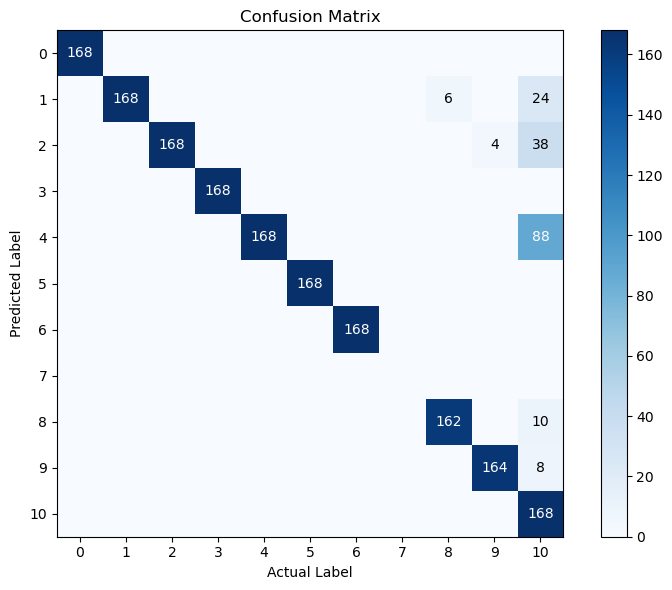

In [94]:
import matplotlib.pyplot as plt
import numpy as np


NUM_LABELS = 11

test_error, confusions = error_rate(np.asarray(preds), np.asarray(labels), num_classes=NUM_LABELS)
print("Test Error: %.1f%%" % test_error)

plt.figure(figsize=(8, 6))
plt.imshow(confusions, cmap=plt.cm.Blues, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.colorbar()

tick_marks = np.arange(NUM_LABELS)
plt.xticks(tick_marks)
plt.yticks(tick_marks)

# Annotate each cell with count
for i in range(NUM_LABELS):
    for j in range(NUM_LABELS):
        count = confusions[i, j]
        if count > 0:
            plt.text(j, i, str(count), ha="center", va="center", color="white" if count > np.max(confusions)/2 else "black")

plt.tight_layout()
plt.show()


In [95]:
class_names = label_encoder.classes_
print(class_names)

['Andaman cat snake' 'Andaman cobra' 'Black headed Python'
 'Black necked spitting cobra' 'Black racer snake' 'Black rat snake'
 'Dekay Brown snake' 'Dumeril Black headed snake'
 'Dumeril Blackheaded snake' 'Eastern Brown Snake' 'Eyelash viper']


In [97]:
for i in range(0,len(class_names)):
    print(f"{i} = {class_names[i]}")

0 = Andaman cat snake
1 = Andaman cobra
2 = Black headed Python
3 = Black necked spitting cobra
4 = Black racer snake
5 = Black rat snake
6 = Dekay Brown snake
7 = Dumeril Black headed snake
8 = Dumeril Blackheaded snake
9 = Eastern Brown Snake
10 = Eyelash viper
